In [1]:
from mlcolvar.data import DictModule
from mlcolvar.utils.io import create_dataset_from_trajectories
from mlcolvar.utils.io import create_dataset_from_files


dataset_graph = create_dataset_from_trajectories(
    trajectories=[
        '/home/etrizio@iit.local/notebooks/projects/kolmogorov/alanine_transform/unbiased_sims/state_A/traj_comp.xtc',
        '/home/etrizio@iit.local/notebooks/projects/kolmogorov/alanine_transform/unbiased_sims/state_B/traj_comp.xtc',
        '/home/etrizio@iit.local/notebooks/projects/kolmogorov_opes/alanine_long_train/biased_sims/iter_4/A/traj_comp.xtc',
        # '/home/etrizio@iit.local/notebooks/projects/kolmogorov_opes/alanine_long_train/biased_sims/iter_4/B/traj_comp.xtc'
        # 'data/r.dcd',
        # 'data/p.dcd',
        # 'data/biased.trajectory.h5',
        # 'data/biased.dcd',
        #'data/biased.trajectory.h5',
        #'data/r.dcd'
    ],
    top=['/home/etrizio@iit.local/notebooks/projects/kolmogorov/alanine_transform/unbiased_sims/state_A/confout.gro',
         '/home/etrizio@iit.local/notebooks/projects/kolmogorov/alanine_transform/unbiased_sims/state_A/confout.gro',
         '/home/etrizio@iit.local/notebooks/projects/kolmogorov/alanine_transform/unbiased_sims/state_A/confout.gro'
        # 'data/r.pdb', 
        #  'data/p.pdb',
        #  'data/r.pdb',
         #'data/r.pdb'
         ],
    cutoff=8.0,  # Ang
    create_labels=True,
    system_selection='all and not type H',
    show_progress=False
)


datamodule_graph = DictModule(dataset_graph, lengths=[1], shuffle=False)
print(datamodule_graph)

DictModule(dataset -> DictDataset( "data_list": 28603, "z_table": [6, 7, 8], "cutoff": 8.0, "data_type": graphs ),
		     train_loader -> DictLoader(length=1, batch_size=28603, shuffle=False))


In [2]:
import torch
from mlcolvar.utils.io import load_dataframe

T = 300 
# Boltzmann factor in the RIGHT ENRGY UNITS!
kb = 0.0083144621
beta = 1/(kb*T)

df = load_dataframe('/home/etrizio@iit.local/notebooks/projects/kolmogorov_opes/alanine_long_train/biased_sims/iter_4/A/COLVAR', stride=1)
weights = torch.exp(1/beta*torch.tensor((df['opes.bias'] + df['bias']).values))
weights = weights / weights.sum()
weights

aux = torch.zeros(len(dataset_graph))
for i in range(len(weights)):
    aux[-(len(weights)-i)] = weights[i]
aux

for i in range(len(dataset_graph)):
    dataset_graph['data_list'][i]['weight'] = aux[i]

In [2]:
len(dataset_graph)

28603

In [4]:
from mlcolvar.cvs.committor import Committor
from mlcolvar.core.nn.graph.schnet import SchNetModel
import torch

gnn_model = SchNetModel(n_out=1,
                        cutoff=dataset_graph.metadata['cutoff'],
                        atomic_numbers=dataset_graph.metadata['z_table'],
                        n_bases=16,
                        n_layers=2,
                        n_filters=32,
                        n_hidden_channels=32,
                    )

# model = Committor(model=gnn_model,
#                   mass=torch.Tensor([12, 19]),
#                   alpha=1)


model = Committor(model=gnn_model,
                  mass=torch.Tensor([12, 14, 16]),
                  alpha=1)


model

/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


Committor(
  (loss_fn): CommittorLoss()
  (nn): SchNetModel(
    (_radial_embedding): RadialEmbeddingBlock(
      (bessel_fn): GAUSSIANBASIS [ 16 󰯰 | 8.000000 󰳁 ]
    )
    (W_v): Linear(in_features=3, out_features=32, bias=False)
    (layers): ModuleList(
      (0-1): 2 x InteractionBlock(
        (mlp): Sequential(
          (0): Linear(in_features=16, out_features=32, bias=True)
          (1): ShiftedSoftplus()
          (2): Linear(in_features=32, out_features=32, bias=True)
        )
        (conv): CFConv()
        (act): ShiftedSoftplus()
        (lin): Linear(in_features=32, out_features=32, bias=True)
      )
    )
    (W_out): ModuleList(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): ShiftedSoftplus()
      (2): Linear(in_features=16, out_features=1, bias=True)
    )
  )
  (sigmoid): Custom_Sigmoid()
)

In [5]:
from lightning import Trainer

trainer = Trainer(
    logger=False,
    enable_checkpointing=False,
    accelerator='cuda',
    max_epochs=500,
    enable_model_summary=False,
    limit_val_batches=0, 
    num_sanity_val_steps=0
)

trainer.fit(model, datamodule_graph)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 316.00 MiB. GPU 0 has a total capacty of 7.79 GiB of which 244.31 MiB is free. Including non-PyTorch memory, this process has 6.88 GiB memory in use. Of the allocated memory 6.61 GiB is allocated by PyTorch, and 158.40 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [35]:
loader = datamodule_graph
test = next(iter(loader.train_dataloader()))['data_list']
out_graph = model(test)

In [36]:
out_graph

tensor([[1.1561e-08],
        [1.6096e-09],
        [1.0000e+00],
        ...,
        [1.0000e+00],
        [1.3562e-09],
        [1.0000e+00]], grad_fn=<MulBackward0>)

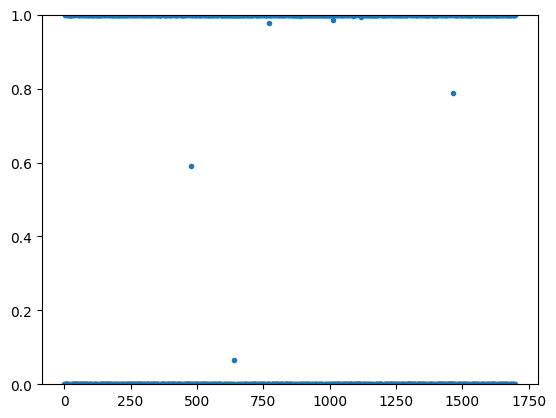

In [37]:
import matplotlib.pyplot as plt

# plt.hist(out_graph.detach().squeeze())
plt.plot(out_graph.detach().squeeze(), '.')
plt.ylim(0,1)
plt.show()